[Source]
https://www.ncloud-forums.com/topic/307/

Vector DB인 Milvus와 관련된 모듈들은 모듈의 용도를 명확히 구분하기 위해 Vector DB 구축 단계에서 불러왔으며 해당 부분에서 코드를 확인하실 수 있습니다.

In [ ]:
import json
import os
import subprocess
from pathlib import Path
import http.client

import requests
from tqdm import tqdm
from langchain_community.document_loaders.html import UnstructuredHTMLLoader

## 1. Raw Data -> Connecting
데이터를 추후 작업을 위해 가져오는 단계입니다.<br>
직접 크롤링을 하지 않고, txt 파일(clovastudiourl.txt)에 사용하고 싶은 사이트 URL을 작성한 후, curl 라이브러리와 LangChain의 로더를 통해 작업할 수 있는 형태로 HTML 데이터를 변환했습니다.<br>
또한, 로딩한 데이터 안에 사이트 URL을 넣어 추후 답변과 함께 사이트 주소가 출력되게 하여 질문한 사용자가 답변의 내용이 있는 실제 URL을 함께 참조할 수 있게 로딩된 데이터를 수정했습니다.

**txt → html 변환 및 원본 사이트 주소 mapping**

In [ ]:
url_to_filename_map = {}
 
with open("clovastudiourl.txt", "r") as file:
    urls = [url.strip() for url in file.readlines()]
 
folder_path = "clovastudioguide"
 
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
 
for url in urls:
    filename = url.split("/")[-1] + ".html"
    file_path = os.path.join(folder_path, filename)
    subprocess.run(["curl", "-o", file_path, url], check=True)
    url_to_filename_map[url] = filename
 
with open("url_to_filename_map.json", "w") as map_file:
    json.dump(url_to_filename_map, map_file)

<details>
<summary>Quote</summary>
<br>
<div markdown="1">
txt 파일을 작성할 때는 한 줄에 하나의 URL을 작성해야 합니다. 이때, 각 URL은 줄바꿈으로 구분되어야 합니다.

그리고 html 데이터를 로딩하기 전, robots.txt를 통해 데이터로 활용할 사이트의 접근 허용 여부를 확인해야합니다. NCP의 클로바스튜디오 사용 가이드의 경우 User-agent: * Allow:/ 로 접근이 가능합니다.

예제에서 활용한 HTML은, 네이버클라우드 플랫폼(NCP)의 클로바스튜디오 사용 가이드중 CLOVA Studio("AI Services" → "CLOVA Studio")와 관련된 모든 안내 페이지를 데이터로 활용했습니다.

LangChain을 활용해 로딩한 html은, 파일을 저장한 디렉토리의 주소를 metadata의 'source'로 가져오게 됩니다. 추후 답변 제공시, 디렉토리 주소가 아닌 실제 URL을 제공하기 위해, LangChain이 로딩한 데이터를 수정해야합니다.

html을 로딩할 때 파일명을 URL로 할 경우, /와 : 기호로 인해 파일명이 깨지게 됩니다. 따라서 원본 URL과 로딩한 HTML 파일을 쌍으로 mapping하고, 이 정보를 json 형식으로 "url_to_filename_map"에 저장합니다.

이후, html 파일의 저장 경로가 담긴 'source'를, 이 json 파일과 연결해 실제 URL로 변환해줍니다. 위 코드는, json 파일을 저장하는 단계까지입니다.

</div>
</details>

**LangChain 활용 HTML 로딩**

이전 단계에서 txt 파일을 HTML로 변환한 후, Langchain의 UnstructuredHTMLLoader를 사용하여 이후 문단 나누기와 임베딩을 위해 machine readable한 형태로 변환해 줍니다.

In [ ]:
# 폴더 이름에 맞게 수정
import os
html_files_dir = Path(os.path.join(os.getcwd(), 'clovastudioguide'))
 
html_files = list(html_files_dir.glob("*.html"))
 
clovastudiodatas = []
 
for html_file in html_files:
    loader = UnstructuredHTMLLoader(str(html_file))
    document_data = loader.load()
    clovastudiodatas.append(document_data)
    print(f"Processed {html_file}")

In [ ]:
clovastudiodatas

<details>
<summary>Quote</summary>
<br>
<div markdown="1">
각 HTML에는 page_content에 모든 텍스트가, metadata의 'source'에는 저장 경로가 기록되어 있습니다.<br>
위는, 로딩된 데이터 중 하나인 clovastudio-info.html의 형태입니다. metadata의 'source'에 실제 URL이 아닌 html 파일이 저장된 디렉토리 경로가 담긴 것을 확인할 수 있습니다.<br>
Mapping을 통해 이 'source'를 실제 URL로 바꾸는 작업을 다음 단계에 진행하게 됩니다.
</div>
</details>


**Mapping 정보를 활용해 'source'를 실제 URL로 대체**

아래의 output은 앞선 예시인 clovastudio-info.html의 형태입니다.<br>
Mapping 정보를 활용하여 'source'의 값을 실제 URL로 변환한 것을 확인할 수 있습니다.

In [ ]:
with open("url_to_filename_map.json", "r") as map_file:
    url_to_filename_map = json.load(map_file)
 
filename_to_url_map = {v: k for k, v in url_to_filename_map.items()}
 
# clovastudiodatas 리스트의 각 Document 객체의 'source' 수정
for doc_list in clovastudiodatas:
    for doc in doc_list:
        extracted_filename = doc.metadata["source"].split("/")[-1]
        if extracted_filename in filename_to_url_map:
            doc.metadata["source"] = filename_to_url_map[extracted_filename]
        else:
            print(f"Warning: {extracted_filename}에 해당하는 URL을 찾을 수 없습니다.")

In [ ]:
# 이중 리스트를 풀어서 하나의 리스트로 만드는 작업
clovastudiodatas_flattened = [item for sublist in clovastudiodatas for item in sublist]
clovastudiodatas_flattened

## 2. Chunking
임베딩 모델이 처리할 수 있는 적당한 크기로 raw data를 나누는 것은 매우 중요합니다.<br>
이는 임베딩 모델마다 한 번에 처리할 수 있는 토큰 수의 한계가 있기 때문입니다.<br>
CLOVA Studio의 문단 나누기 API는 모델이 직접 문장들간의 의미 유사도를 찾아 최적의 chunk 개수와 사용자가 원하는 1개 chunk의 크기(글자 수)를 직접 설정하여 문단을 나눌 수도 있습니다.<br>
추가로, 후처리(postProcess = True)를 통해 chunk당 글자 수의 상한선과 하한선을 postProcessMaxSize와 postProcessMinSize로 조절할 수도 있습니다.

In [ ]:
class SegmentationExecutor:
    def __init__(self, host, api_key, api_key_primary_val, request_id):
        self._host = host
        self._api_key = api_key
        self._api_key_primary_val = api_key_primary_val
        self._request_id = request_id
 
    def _send_request(self, completion_request):
        headers = {
            "Content-Type": "application/json; charset=utf-8",
            "X-NCP-CLOVASTUDIO-API-KEY": self._api_key,
            "X-NCP-APIGW-API-KEY": self._api_key_primary_val,
            "X-NCP-CLOVASTUDIO-REQUEST-ID": self._request_id
        }
 
        conn = http.client.HTTPSConnection(self._host)
        conn.request(
            "POST",
            "/testapp/v1/api-tools/segmentation/{테스트앱 식별자}",
            json.dumps(completion_request),
            headers
        )
        response = conn.getresponse()
        result = json.loads(response.read().decode(encoding="utf-8"))
        conn.close()
        return result
 
    def execute(self, completion_request):
        res = self._send_request(completion_request)
        if res["status"]["code"] == "20000":
            return res["result"]["topicSeg"]
        else:
            return "Error"
 
 
if __name__ == "__main__":
    segmentation_executor = SegmentationExecutor(
        host="clovastudio.apigw.ntruss.com",
        api_key='<api_key>',
        api_key_primary_val='<api_key_primary_val>',
        request_id='<request_id>'
    )
 
    chunked_html = []
 
    for htmldata in tqdm(clovastudiodatas_flattened):
        request_json_string = f"""{{
            "postProcessMaxSize": 100,
            "alpha": 1.5,
            "segCnt": -1,
            "postProcessMinSize": 0,
            "text": "{htmldata.page_content}",
            "postProcess": false
        }}"""
 
        request_data = json.loads(request_json_string, strict=False)
        response_data = segmentation_executor.execute(request_data)
        # 반환된 각 문단에 대해 source(주소) 포함하여 chunked_documents에 추가
        for paragraph in response_data:
            chunked_document = {
                "source": htmldata.metadata["source"],
                "text": paragraph
            }
            chunked_html.append(chunked_document)
 
print(len(chunked_html))

<details>
<summary>Quote</summary>
<br>
<div markdown="1">
파이썬 스펙을 확인하기 위해서는 테스트 앱을 발급받아야 합니다. 테스트 앱에는 고유한 식별자(코드)인 **{테스트앱 식별자}**가 부여됩니다.
<br><br>
테스트 앱이 요청한 작업에는 <api_key>, <api_key_primary_val>, **<request_id>**와 같은 3가지 정보가 사용되며, 이는 사용자 계정마다 고유한 값입니다.
<br><br>
파이썬 스펙에서는 필요한 모듈을 불러오는 부분이 상단에 위치하지만, 이 파이프라인에서는 초반에 한 번에 로딩하였습니다. 또한, 파이썬 스펙에서는 클래스 이름이 "CompletionExecutor"로 명시되어 있으나, 다른 API와의 이름 중복을 피하기 위해 "SegmentationExecutor"로 임의 변경하였습니다.
</div>
</details>


## 3. Embedding

문단 나누기 API를 통해 나누어진 525개의 chunk(chunked_html)을 CLOVA Studio의 임베딩 API를 사용해 1024차원의 벡터로 변환하는 과정입니다.<br>
clir-emb-dolphin의 경우, 임베딩 과정에서 유사도 판단을 위해 벡터의 내적(Inner Product, IP)을 거리 단위로 사용합니다.<br>
반면, clir-sts-dolphin은 코사인 거리(Cosine)를 거리 단위로 사용합니다.<br>
이후, 벡터의 인덱싱과 검색 과정에서 사용자는 어떤 거리 단위를 사용하여 데이터와 사용자의 쿼리 간 유사도를 판단할 것인지 선택할 수 있습니다.

거리 단위를 임베딩부터 인덱싱, 검색까지 일치시켜야 데이터의 품질이 향상되므로, 임베딩 과정에서 사용한 모델(emb / sts)을 기억하는 것이 중요합니다.<br>
임베딩 클래스에 오류가 발생시 멈추게끔 하는 로직을 일부 추가해, 다량의 데이터를 처리할 때 오류 발생시 재실행의 부담을 줄입니다.

In [ ]:
class EmbeddingExecutor:
    def __init__(self, host, api_key, api_key_primary_val, request_id):
        self._host = host
        self._api_key = api_key
        self._api_key_primary_val = api_key_primary_val
        self._request_id = request_id
 
    def _send_request(self, completion_request):
        headers = {
            "Content-Type": "application/json; charset=utf-8",
            "X-NCP-CLOVASTUDIO-API-KEY": self._api_key,
            "X-NCP-APIGW-API-KEY": self._api_key_primary_val,
            "X-NCP-CLOVASTUDIO-REQUEST-ID": self._request_id
        }
 
        conn = http.client.HTTPSConnection(self._host)
        conn.request(
            "POST",
            "/testapp/v1/api-tools/embedding/clir-emb-dolphin/{테스트앱 식별자}",
            json.dumps(completion_request),
            headers
        )
        response = conn.getresponse()
        result = json.loads(response.read().decode(encoding="utf-8"))
        conn.close()
        return result
 
    def execute(self, completion_request):
        res = self._send_request(completion_request)
        if res["status"]["code"] == "20000":
            return res["result"]["embedding"]
        else:
            error_code = res["status"]["code"]
            error_message = res.get("status", {}).get("message", "Unknown error")
            raise ValueError(f"오류 발생: {error_code}: {error_message}")
 
 
if __name__ == "__main__":
    embedding_executor = EmbeddingExecutor(
        host="clovastudio.apigw.ntruss.com",
        api_key='<api_key>',
        api_key_primary_val='<api_key_primary_val>',
        request_id='<request_id>'
    )
 
    try:
        for i, chunked_document in enumerate(tqdm(chunked_html)):
            request_json_string = f"""{{
                "text": "{chunked_document['text']}"
            }}"""
            request_data = json.loads(request_json_string, strict=False)
            embedding = embedding_executor.execute(request_data)
            chunked_document["embedding"] = embedding
    except ValueError as e:
        print(f"Error at document index {i} with error: {e}")

<details>
<summary>Quote</summary>
<br>
<div markdown="1">
이 예제에서는 clir-emb-dolphin을 임베딩 모델로 사용했으며, 이후 인덱싱과 검색에서도 거리 단위를 IP로 활용할 것입니다.
</div>
</details>


In [ ]:
dimension_set = set()
 
for item in chunked_html:
    if "embedding" in item:
        dimension = len(item["embedding"])
        dimension_set.add(dimension)
 
print("임베딩된 벡터들의 차원:", dimension_set)

In [ ]:
chunked_html[400]

## 4. Vector DB
CLOVA Studio의 임베딩 API를 활용하여 모든 chunked_의 text를 1024차원의 벡터로 변환한 후, 'embedding'이라는 이름의 객체로 chunked_html에 추가해 주었습니다.<br>
이제 이 데이터를 Vector DB에 저장하고, 인덱싱을 하는 단계입니다.<br>
Vector DB로는 Milvus를 사용하였으며, 대시보드는 Docker를 사용하여 DB를 켜고(Run) 끄는(Stop) 작업을 수행하였습니다.

**Milvus Set Up**

In [ ]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

MacOS 환경에서 Docker를 설치한 뒤, 터미널을 사용하여 git clone 명령어로 Milvus Standalone을 설치했습니다.<br>
Milvus Standalone 모드는 단일 노드 또는 서버에서 모든 기능을 제공하며, 필요한 모든 컴포넌트가 하나의 인스턴스나 컨테이너 안에서 작동합니다.<br>
이는 주로 소규모 프로젝트나 개발 단계에 이상적입니다.<br>
프로젝트에 파이썬을 사용함에 따라, Milvus를 효과적으로 활용하기 위해 파이썬용 SDK인 Pymilvus를 설치하고 필요한 라이브러리를 가져왔습니다.

**Collections & ID 생성**

In [ ]:
connections.connect()
  
fields = [
    FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=True),
    FieldSchema(name="source", dtype=DataType.VARCHAR, max_length=3000),
    FieldSchema(name="text", dtype=DataType.VARCHAR, max_length=9000),
    FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=1024)
]

schema = CollectionSchema(fields, description="컬렉션 설명 적어넣기")

collection_name = "컬렉션 이름"
collection = Collection(name=collection_name, schema=schema, using='default', shards_num=2)

for item in chunked_html:
    source_list = [item['source']]
    text_list = [item['text']]
    embedding_list = [item['embedding']]
    
    entities = [
        source_list,
        text_list,
        embedding_list
    ]
    
    insert_result = collection.insert(entities)
    print("데이터 Insertion이 완료된 ID:", insert_result.primary_keys)

print("데이터 Insertion이 전부 완료되었습니다")

<details>
<summary>Quote</summary>
<br>
<div markdown="1">

- 활용 SDK가 업데이트 될 경우 코드에 변화가 발생할 수 있습니다.<br>
- 데이터 chunk가 에러가 발생하여 임베딩 값을 가지고 있지 않을 경우 오류가 발생할 수 있으니, 임베딩이 정상적으로 완료 되었는지 확인해야 합니다.
</div>
</details>


**Indexing**

앞서 임베딩 시 거리 단위를 IP로 설정했기 때문에, 인덱싱에서도 "metric_type"을 "IP"로 설정합니다.<br>
인덱싱 유형은 다양한 알고리즘이 존재하며, 최근에는 HNSW 방식이 많이 활용됩니다. 하지만 선택한 Vector DB가 어떤 인덱싱 유형을 지원하는지 확인해야 합니다.<br>
"M"은 각 노드(데이터 포인트)가 유지할 수 있는 최대 엣지(연결)의 수로, 값이 높을수록 검색 정확도는 높아지지만 인덱스 생성 시간과 메모리 사용량도 증가하는 trade-off 관계를 가지고 있습니다.<br>

"efConstruction"은 인덱스 구축 시 만들 그래프 구조의 깊이와 너비로, 값이 높을수록 정확도는 올라가지만 인덱스 생성 시간과 메모리 사용량도 증가하는 trade-off 관계를 가지고 있습니다.<br>
"M" : 8, "efConstruction" : 200의 설정은 Milvus가 공개한 Milvus 2.2.0의 성능 벤치마크에서 실험 시 설정한 파라미터 값을 가져온 것으로, Cookbook도 Milvus 2.2.x 환경에서 진행되었습니다.<br>
데이터의 양이 많을수록 인덱싱에 시간이 오래 소요될 수 있습니다.<br>
데이터가 많은 경우, 인덱싱 생성 후 바로 결과를 확인하면 결과를 확인할 수 없으며, 인덱싱은 하나의 객체와 값으로 저장되는 것이 아니기 때문에 아래와 같은 실행 결과로 인덱싱이 완료되었는지 확인할 수 있습니다.<br>

In [ ]:
index_params = {
    "metric_type": "IP",
    "index_type": "HNSW",
    "params": {
        "M": 8,
        "efConstruction": 200
    }
}
 
collection = Collection("htmlrag_forncp")
collection.create_index(field_name="embedding", index_params=index_params)
utility.index_building_progress("htmlrag_forncp")
 
print([index.params for index in collection.indexes])

**재실행시 Milvus 로딩 방법**

작업 환경 종료 이후, RAG를 이용해 다시 질의응답을 하려면, Vector DB인 Milvus와 연결 상태여야 합니다. Docker를 Milvus의 대시보드로 사용할 때의 연결 방법은 다음과 같습니다. 질의응답은 html_chat() 함수를 통해 이전과 동일하게 진행할 수 있습니다.

1. Docker를 실행한 후, collections가 저장되어 있는 컨테이너(milvus-standalone)를 실행시켜줍니다.
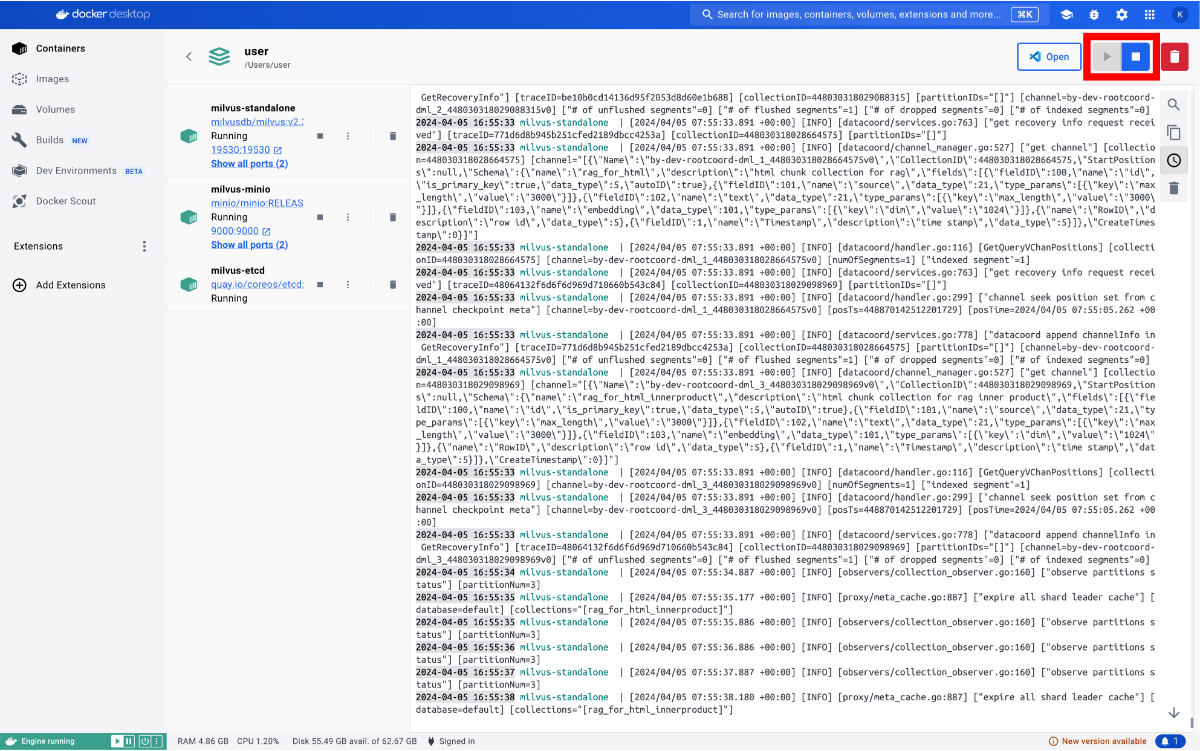
2. 아래의 코드를 통해 connection을 실행하고, 만든 collection의 이름을 넣어 연결합니다. Milvus 및 Milvus-Standalone의 기본 환경은 host = "localhost", port="19530"입니다. 필요한 모듈과 라이브러리는 Milvus에 데이터를 저장할 때와 동일합니다.

In [ ]:
connections.connect("default", host="localhost", port="19530")
 
# 불러올 collection 이름을 넣는 곳
collection = Collection("htmlrag_forncp")
utility.load_state("htmlrag_forncp")

## 5. Retrieval → HyperCLOVA X

사용자의 질문을 임베딩하는 함수와, 임베딩한 사용자의 질문에 대응하는 Vector DB에 저장된 데이터를 검색하는 로직을 구성하는 단계입니다.<br>
검색을 통해 사용자의 질문과 가장 유사한 데이터를 모은 "reference"를 HyperCLOVA X가 참조해 질문에 대한 답변을 생성합니다.<br>
Chat Completion API를 생성하여 답변 생성을 위한 LLM을 호출하며, 플레이그라운드와 동일하게 파라미터(Top P, Top K 등)와 시스템 프롬프트를 작성할 수 있습니다.<br> 

**Chat Completion API**

Chat Completion의 파이썬 스펙은 플레이그라운드의 테스트앱 발급을 통해 확인할 수 있습니다.<br>
기본적으로 Chat Completion API의 실행 결과는, 아래와 같은 stream 형태로 출력됩니다.<br>
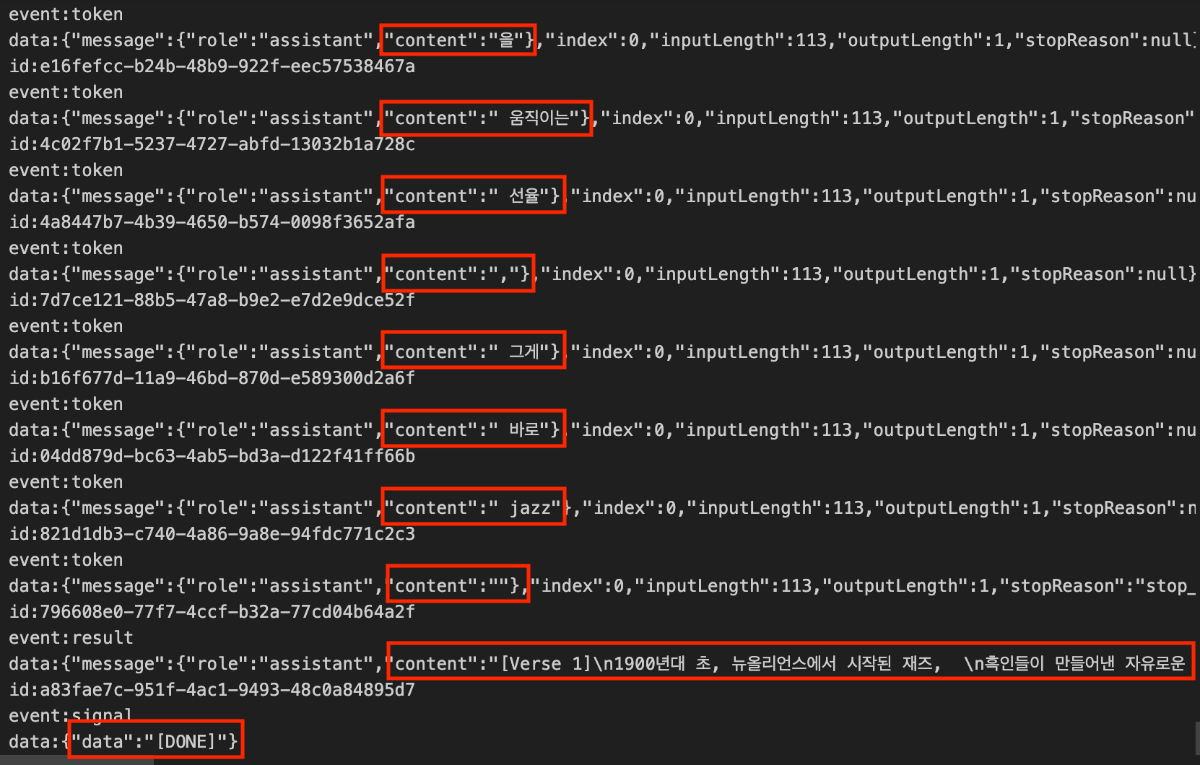

Chat Completion API의 파이썬 스펙을 약간 변형하여 full-length 최종 답변만을 추출할 수 있습니다.<br>
이를 위해 두 가지 로직을 사용할 수 있는데, 첫째는 Stream 답변 중 가장 긴 길이의 답변을 선택하는 방법이고, 둘째는 제일 마지막 출력 결과인 "[DONE]" 바로 직전의 출력 결과를 선택하는 방법입니다. 각각의 방법에 대한 코드는 아래에서 확인하실 수 있습니다.<br>

1. 가장 긴 길이의 답변을 선택하는 경우

In [ ]:
class CompletionExecutor:
    def __init__(self, host, api_key, api_key_primary_val, request_id):
        self._host = host
        self._api_key = api_key
        self._api_key_primary_val = api_key_primary_val
        self._request_id = request_id
 
    def execute(self, completion_request, response_type="stream"):
        headers = {
            "X-NCP-CLOVASTUDIO-API-KEY": self._api_key,
            "X-NCP-APIGW-API-KEY": self._api_key_primary_val,
            "X-NCP-CLOVASTUDIO-REQUEST-ID": self._request_id,
            "Content-Type": "application/json; charset=utf-8",
            "Accept": "text/event-stream"
        }
 
        final_answer = ""
 
        with requests.post(
            self._host + "/testapp/v1/chat-completions/HCX-003",
            headers=headers,
            json=completion_request,
            stream=True
        ) as r:
            if response_type == "stream":
                longest_line = ""
                for line in r.iter_lines():
                    if line:
                        decoded_line = line.decode("utf-8")
                        if decoded_line.startswith("data:"):
                            event_data = json.loads(decoded_line[len("data:"):])
                            message_content = event_data.get("message", {}).get("content", "")
                            if len(message_content) > len(longest_line):
                                longest_line = message_content
                final_answer = longest_line
            elif response_type == "single":
                final_answer = r.json()  # 가정: 단일 응답이 JSON 형태로 반환됨

2. "[DONE]" 바로 직전의 출력 결과를 선택하는 경우

In [ ]:
class CompletionExecutor:
    def __init__(self, host, api_key, api_key_primary_val, request_id):
        self._host = host
        self._api_key = api_key
        self._api_key_primary_val = api_key_primary_val
        self._request_id = request_id
 
    def execute(self, completion_request):
        headers = {
            "X-NCP-CLOVASTUDIO-API-KEY": self._api_key,
            "X-NCP-APIGW-API-KEY": self._api_key_primary_val,
            "X-NCP-CLOVASTUDIO-REQUEST-ID": self._request_id,
            "Content-Type": "application/json; charset=utf-8",
            "Accept": "text/event-stream"
        }
 
        response = requests.post(
            self._host + "/testapp/v1/chat-completions/HCX-003",
            headers=headers,
            json=completion_request,
            stream=True
        )
 
        # 스트림에서 마지막 'data:' 라인을 찾기 위한 로직
        last_data_content = ""
 
        for line in response.iter_lines():
            if line:
                decoded_line = line.decode("utf-8")
                if '"data":"[DONE]"' in decoded_line:
                    break
                if decoded_line.startswith("data:"):
                    last_data_content = json.loads(decoded_line[5:])["message"]["content"]
 
        return last_data_content

<details>
<summary>Quote</summary>
<br>
<div markdown="1">
Stream 형태의 답변 구조에서는 다음과 같은 두 가지 로직을 사용하여 최종 full-length 답변을 추출할 수 있습니다.
<br>
<pre>&nbsp; &nbsp;1. 최종 full-length 답변은 출력 결과들 중 가장 긴 답변이므로, 모든 출력 결과의 길이를 비교하여 가장 긴 답변을 선택합니다.
&nbsp; &nbsp;2. Stream 답변 구조상 "[DONE]" 표시 직전의 출력 결과가 최종 full-length 답변이므로, "[DONE]" 표시 이전의 마지막 출력 결과를 선택합니다.<br></pre>
Cookbook에서는 1번 로직을 사용하여 클래스를 정의했습니다.
</div>
</details>


**답변 생성 함수 정의**

In [ ]:
# 사용자의 쿼리를 임베딩하는 함수를 먼저 정의
def query_embed(text: str):
    request_data = {"text": text}
    response_data = embedding_executor.execute(request_data)
    return response_data

In [ ]:
def html_chat(realquery: str) -> str:
    # 사용자 쿼리 벡터화
    query_vector = query_embed(realquery)
 
    collection.load()
 
    search_params = {"metric_type": "IP", "params": {"ef": 64}}
    results = collection.search(
        data=[query_vector],  # 검색할 벡터 데이터
        anns_field="embedding",  # 검색을 수행할 벡터 필드 지정
        param=search_params,
        limit=10,
        output_fields=["source", "text"]
    )
 
    reference = []
 
    for hit in results[0]:
        distance = hit.distance
        source = hit.entity.get("source")
        text = hit.entity.get("text")
        reference.append({"distance": distance, "source": source, "text": text})
 
    completion_executor = CompletionExecutor(
        host="https://clovastudio.stream.ntruss.com",
        api_key='<api_key>',
        api_key_primary_val='<api_key_primary_val>',
        request_id='<request_id>'
    )
 
    preset_texts = [
        {
            "role": "system",
            "content": "- 너의 역할은 사용자의 질문에 reference를 바탕으로 답변하는거야. \n- 너가 가지고있는 지식은 모두 배제하고, 주어진 reference의 내용만을 바탕으로 답변해야해. \n- 답변의 출처가 되는 html의 내용인 'source'도 답변과 함께 {url:}의 형태로 제공해야해. \n- 만약 사용자의 질문이 reference와 관련이 없다면, {제가 가지고 있는 정보로는 답변할 수 없습니다.}라고만 반드시 말해야해."
        }
    ]
 
    for ref in reference:
        preset_texts.append(
            {
                "role": "system",
                "content": f"reference: {ref['text']}, url: {ref['source']}"
            }
        )
 
    preset_texts.append({"role": "user", "content": realquery})
 
    request_data = {
        "messages": preset_texts,
        "topP": 0.6,
        "topK": 0,
        "maxTokens": 1024,
        "temperature": 0.5,
        "repeatPenalty": 1.2,
        "stopBefore": [],
        "includeAiFilters": False
    }
 
    # LLM 생성 답변 반환
    response_data = completion_executor.execute(request_data)
 
    return response_data

<details>
<summary>Quote</summary>
<br>
<div markdown="1">

- Search 역시 "metric_type" = "IP"로 설정해 임베딩과 인덱싱의 거리 단위와 일치시켜줍니다. 이때, "ef" 값을 64로 설정한 것은 Milvus 2.2.0의 성능 벤치마크에서 사용된 설정을 참고한 것입니다.

- results 내 limit = 10의 경우 상위 10개의 문서를 가져온다는 의미인데, Milvus가 우수한 성능을 보여준 2023 ANN Benchmarks에서의 실험 세팅인 k = 10을 그대로 가져온 것입니다.

- 이렇게 선정된 상위 10개의 문서를 'reference'라는 리스트로 만들고, 이를 바탕으로 HyperCLOVA X가 오로지 이 리스트를 참조하여 답변하도록 프롬프팅을 설정했습니다. 또한, 추가적인 프롬프팅을 통해 데이터를 기반으로 한 질문에만 답변하도록 하며, 정보가 없을 경우 이를 인정할 수 있는 지침을 부여했습니다.
</div>
</details>
